In [15]:
# Basic Settings for Jupyter Notebook
def title(string, icon='-'):print(string.center(100,icon))
np.set_printoptions(precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.random.seed(8)
import warnings
warnings.filterwarnings('ignore')

In [16]:
# SHAPIRO TEST (STATISTICAL WAY of NORMAL DISTRIBUTION CHECK)
def ShapiroTest(data_name,data,verbose=True):
    '''
    input column name and data in single dimension
    return Boolean (if shapiro test passed then True, else False)
    '''
    from scipy.stats import shapiro; n_icon = 123;
    H0 = f'H0: {data_name}  = normally distributed'
    Ha = f'Ha: {data_name} != normally distributed'
    if verbose:print(n_icon*'=');print('\t|',H0,'|\t[Null Hypothesis]');print('\t|',Ha,'|\t[Alternate Hypothesis]')
    _, pval = shapiro(data)
    if verbose:print('The P-value(Probability of Null Hypothesis being True) is',pval);print(n_icon*'-')
    if pval < 0.05:
        if verbose:print(f'Since the P-Value({pval}) is less than 0.05, \n\tWe reject the Null Hypothesis("{H0}")\
    \nHence, Our Alternate Hyposthesis "{Ha}" holds Good')
        return False
    elif pval > 0.05:
        if verbose:print(f'Since the P-Value({pval}) is more than 0.05, \n\tWe fail to reject the Null Hypothesis("{H0}")\
    \nTherefore "{data_name}" is normally distributed');
        return True

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data UnderStanding

In [18]:
df = pd.read_excel('slcmidexampaper/Bank_Personal_Loan_Modelling.xlsx',index_col = 0)
df['Education_cat'] = df['Education'].astype('object')
for col in ['ZIP Code','Personal Loan']:df[col] = df[col].astype('object')# Converting to category 
# Identifying type of columns
target = 'Personal Loan'
non_features = [target,]
num_features = [col for col in df.select_dtypes(np.number).columns if col not in non_features]
cat_features = [col for col in df.select_dtypes('object').columns if col not in non_features]
df[target] = df[target].map({1:'Yes',0:'No'})
df['Education_cat']=df['Education_cat'].map({1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Professional'})

> OBSERVATIONS
1. Zip code has 467	unique ids
2. Education_cat has 3 unique Features - 'Undergrad', 'Graduate', 'Advanced/Professional'
3. Most Frequeent is underGraduate
4. Target column has More 'No' values, unique are 'yes', 'no'


## Check for defects in the data such as missing values, null, outliers, and class imbalance

TotalNullValues 0


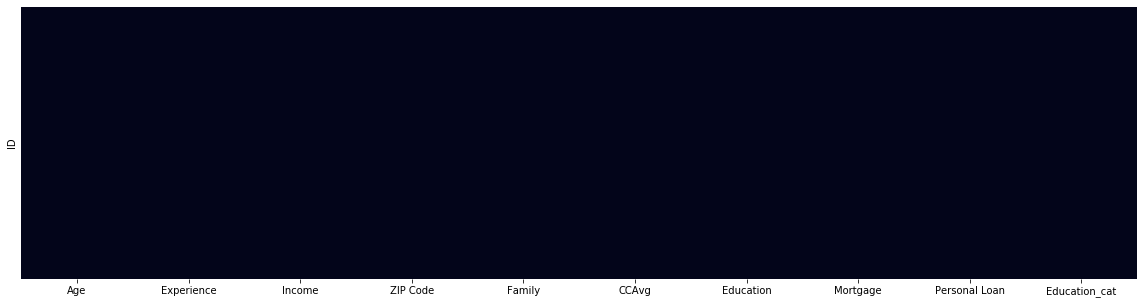

In [19]:
plt.figure(figsize=(20,5));sns.heatmap(df.isnull(),yticklabels=False,cbar=False)
print('TotalNullValues',df.isnull().sum().sum())

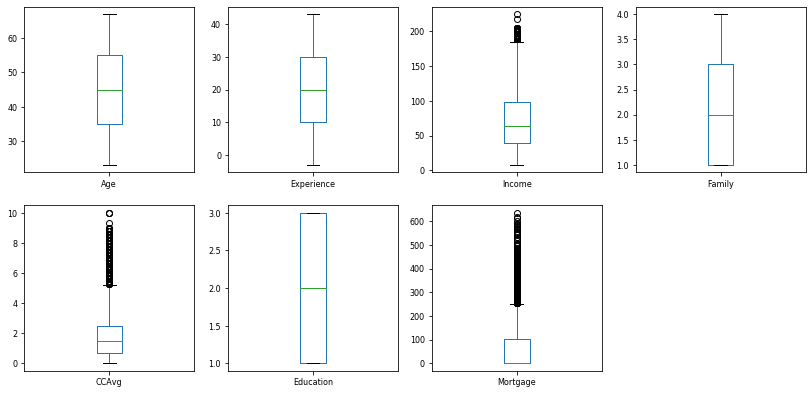

In [20]:
df[num_features].plot(kind='box',subplots=True, layout=(4,4), fontsize=8, figsize=(14,14));

> Observation
* Income, CCAvg, Mortgage columsn have ouliers
* Family column data is right skewed as well

No    0.904
Yes   0.096
Name: Personal Loan, dtype: float64


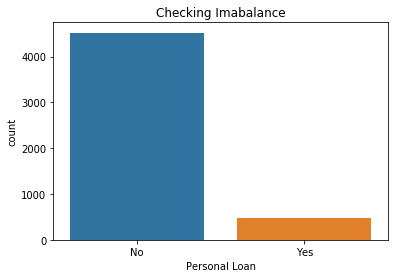

In [21]:
print(df[target].value_counts(normalize=True));sns.countplot(df[target]);plt.title('Checking Imabalance');plt.show()

> OBSERVATION
* High Class Imbalance
* Since Dataset is comparetviely smaller better to go with Over_sampling

## Data Preparation

In [22]:
QualityDict = {'normal':[],'not_normal':[],'categorical':[]}
for col in num_features:
    if ShapiroTest(data_name = col,data = df[col], verbose=False):QualityDict['normal'].append(col)
    else:QualityDict['not_normal'].append(col)
print(QualityDict['not_normal']);print(QualityDict['normal'])

['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage']
[]


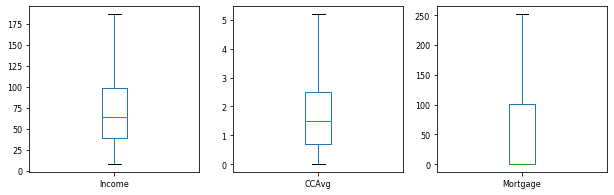

In [23]:
skewed = ['Family'];withOutliers = ['Income', 'CCAvg', 'Mortgage']
IQR=df[withOutliers].describe().T['75%']-df[withOutliers].describe().T['25%']
LW,UW = df[withOutliers].describe().T['25%']-(IQR*1.5),df[withOutliers].describe().T['75%']+(IQR*1.5)
for i in withOutliers:df[i][df[i]>UW[i]]=UW[i];df[i][df[i]<LW[i]]=LW[i]
df[withOutliers].plot(kind='box',subplots=True, layout=(4,4), fontsize=8, figsize=(14,14));

In [24]:
# Feature Scaling or Log

### Bivariate plot to check if variables which are correlated with Target

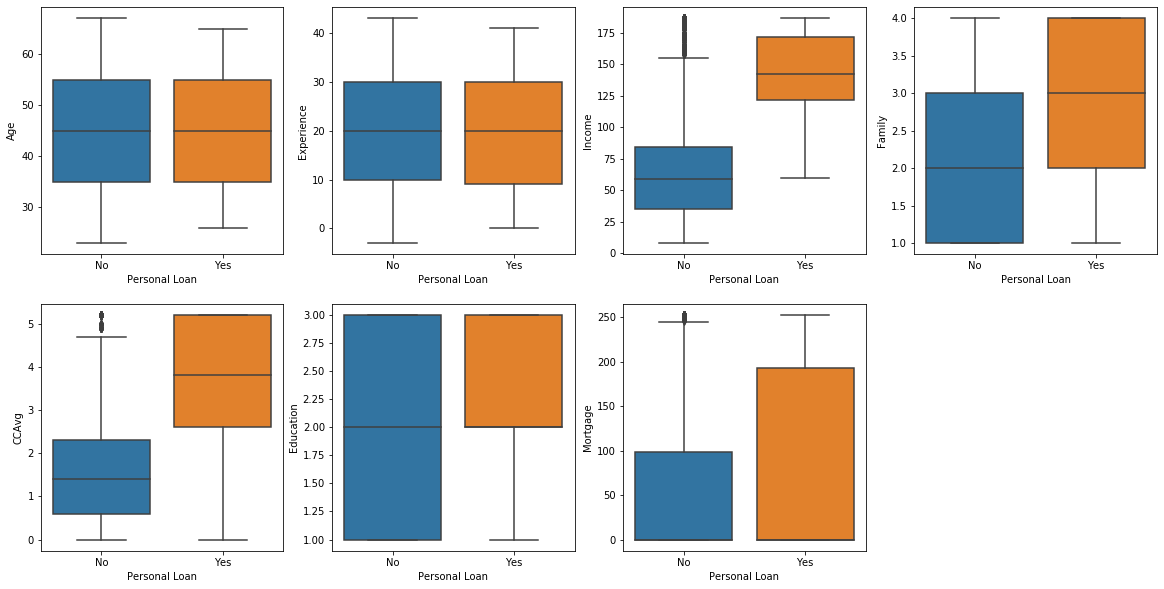

In [25]:
plt.figure(figsize=(20,10))
for i,col in enumerate(num_features,start=1):plt.subplot(2,4,i);sns.boxplot(y=df[col],x=df[target]);
plt.show()

> income, family, CCAvg, Education filds show some siginificant influence on target

> Notes
* Except Income, Family, CCAvg, education shows some influence. So we use and probably remove other numerical features.
* But I have to wait to see how algorithm finally says
* Will remove Zip code also

## Split dataset into train and test

In [26]:
non_features = [target,'ZIP Code']# removing ZIP Codel colum from features
num_features = [col for col in df.select_dtypes(np.number).columns if col not in non_features]
cat_features = [col for col in df.select_dtypes('object').columns if col not in non_features]
print('Numerical Features:',num_features); print('Categorical Features:',cat_features)

Numerical Features: ['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage']
Categorical Features: ['Education_cat']


In [30]:
df.drop('ZIP Code',axis=1).to_csv('Bank_Personal_Loan_before_encoding.csv')

In [14]:
features = num_features+cat_features
df = pd.concat([pd.get_dummies(df[features]),df[[target]]], axis=1)
df[target]=df[target].map({'No':0,'Yes':1})

In [247]:
# split data into features and target
X = df.drop([target], axis=1)
y = df[target]
#Split data into training and testing.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

-----------------------------------------Checking Imbalance-----------------------------------------
0   0.906
1   0.094
Name: Personal Loan, dtype: float64
----------------------------------Treating Imbalance on Train Data----------------------------------
------------------------------------------After Balancing-------------------------------------------
1   0.500
0   0.500
Name: Personal Loan, dtype: float64
****************************************************************************************************


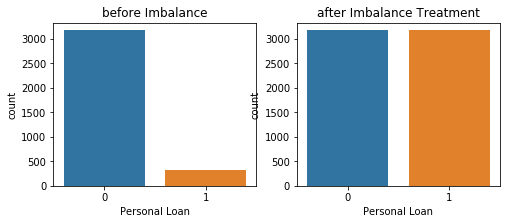

In [248]:
# Treating Imbalance
title('Checking Imbalance');print(y_train.value_counts(normalize=True))#;sns.countplot(y_train);plt.title('BEFORE');
title('Treating Imbalance on Train Data')
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
SM = SMOTE(random_state=8, ratio=1.0)
X_train_SM, y_train_SM = SM.fit_sample(X_train, y_train)
X_train_SM = pd.DataFrame(X_train_SM, columns=X_train.columns)
y_train_SM = pd.Series(y_train_SM,name=target);
title('After Balancing')
print(y_train_SM.value_counts(normalize=True));
title('*',"*");plt.figure(figsize=(8,3));
plt.subplot(1,2,1);sns.countplot(y_train);plt.title('before Imbalance');
plt.subplot(1,2,2);sns.countplot(y_train_SM);plt.title('after Imbalance Treatment');

## MODELING FUNCTION

In [515]:
data = X_train, X_test, y_train, y_test

In [516]:
#importing Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from sklearn.svm import SVC

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier # inspired by LGBM

from lightgbm import LGBMClassifier

LR = dict(name ='LogisticRegression',model = LogisticRegression(),
     parameters = {"penalty": ['l1', 'l2'],'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
     best_parameters = {})
DT = dict(name ='DecisionTreeClassifier',model = DecisionTreeClassifier(),
     parameters = {'criterion': ['gini', 'entropy'],'splitter': ['best', 'random'],
                   'max_depth': [None,2,3,4,5,6,7,8,9,10], 'max_features': ['auto', 'log2',None],
                   'random_state': [8],'min_samples_leaf' : [1,2,3,4,5]},
     best_parameters = {})

KNN= dict(name = 'KNeighborsClassifier',
          model = KNeighborsClassifier(),
          parameters = {'n_neighbors': [i for i in range(1,25)],
                        'p':[1,2]}, # 1=manhattan, 2, euclidean
         best_parameters = {})

GNB= dict(name = 'GaussianNB',
          model = GaussianNB(),
          parameters = {'priors':[None,],'var_smoothing':[1e-09,]},
          best_parameters = {})
BNB= dict(name = 'BernoulliNB',
          model = BernoulliNB(),
          parameters = {'alpha':[1.0,],
                        'binarize':[0.0,],
                        'fit_prior':[True,False],
                        'class_prior':[None]},
          best_parameters = {})

RF= dict(name = 'RandomForestClassifier',
          model = RandomForestClassifier(),
          parameters = {'max_depth': [2, 3, 4],
                        'bootstrap': [True, False],
                        'max_features': ['auto', 'sqrt', 'log2', None],
                        'criterion': ['gini', 'entropy'],
                        'random_state': [8]},
         best_parameters = {})
SVM= dict(name = 'SVC',
          model = SVC(),
          parameters = {'C': [1, 10, 100,500, 1000], 'kernel': ['linear','rbf'],
                        'C': [1, 10, 100,500, 1000], 'gamma': [1,0.1,0.01,0.001, 0.0001], 'kernel': ['rbf'],
                        #'degree': [2,3,4,5,6] , 'C':[1,10,100,500,1000] , 'kernel':['poly']
                                },
          best_parameters = {})


BAG_params={'base_estimator': [DecisionTreeClassifier(),
                               DecisionTreeClassifier(max_depth=2),
                               DecisionTreeClassifier(max_depth=4),
                               BernoulliNB(),
                               LogisticRegression(penalty='l1'),
                               LogisticRegression(penalty='l2'),
                               ], #GaussianNB(),],
            'n_estimators': [10,], 
            'max_samples': [1.0], 'max_features': [1.0], 
            'bootstrap': [True,], 'bootstrap_features': [False], 
            'oob_score': [False], #'warm_start': [False], 
            'n_jobs': [None], 'random_state': [8], 'verbose': [0]}

BAG= dict(name = 'BaggingClassifier',
          model= BaggingClassifier(),
          parameters = BAG_params,
          best_parameters = {},
         )

GB = dict(name = 'GradientBoostingClassifier',
          model = GradientBoostingClassifier(),
          parameters = {
              'loss':['deviance','exponential'],
              'learning_rate':[0.1,0.01,1.0],
              'n_estimators':[100,200,25,50,75],
              'subsample':[1.0,0.75,0.5,0.25,0.01], # < 1.0 leads to reduction of variance and increase in bias
                                #  < 1.0 results in Stochastic Gradient Boosting
              'random_state':[8],
              #'ccp_alpha': [0.0,0.0001,0.001,0.01,0.1,1.0]# only in version 0.22
                              #cost-complexity pruning algorithm to prune tree to avoid over fitting
              #'min_samples_split':[2,3,4],
              #'min_samples_leaf':[1,2,3],
              #'min_weight_fraction_leaf':[0],
              #'max_depth':[3,4,5],
              #'min_impurity_decrease':[0],
              #'init':[None],
              #'max_features':[None],
              #'verbose':[0],

          },
          best_parameters = {})
ADA= dict(name = 'AdaBoostClassifier',
          model = AdaBoostClassifier(),
          parameters = {'base_estimator':[DecisionTreeClassifier(max_depth=1),
                                             DecisionTreeClassifier(max_depth=2),
                                             DecisionTreeClassifier(max_depth=3),
                                             DecisionTreeClassifier(max_depth=4),
                                             BernoulliNB(),
                                             #GaussianNB(),
                                         ],
                        'n_estimators':[25,50,75,100],# ,100
                        'learning_rate':[1.0,0.1],
                        #'alogorithm':['SAMME', 'SAMME.R'],
                        'random_state':[8],
                       },
          best_parameters = {})

XGB_params = {'max_depth': [3],'learning_rate': [0.1],'n_estimators': [100,],#50,150,200],
              'verbosity': [1],'objective': ['binary:logistic'],
              'booster': ['gbtree', 'gblinear','dart'], # IMPORTANT
              'tree_method': ['auto', 'exact', 'approx', 'hist'],#, 'gpu_hist' # IMPORTANT
              'n_jobs': [1],'gamma': [0],
              'min_child_weight': [1],'max_delta_step': [0],
              'subsample': [1],
              'colsample_bytree': [1],'colsample_bylevel': [1],'colsample_bynode': [1],
              'reg_alpha': [0],'reg_lambda': [1],'scale_pos_weight': [1],'base_score': [0.5],
              'random_state': [8],'missing': [None]}

XGB= dict(name = 'XGBClassifier',
          model= XGBClassifier(),
          parameters = XGB_params,
          best_parameters = {},
         )

LBGM_params={'boosting_type': ['gbdt','goss'], # ,'dart','rf'
             'num_leaves': [31], 'max_depth': [-1], 'learning_rate': [0.1], 
             'n_estimators': [100], 'subsample_for_bin': [200000], 'objective': [None],
             'class_weight': [None], 'min_split_gain': [0.0], 'min_child_weight': [0.001],
             'min_child_samples': [20], 'subsample': [1.0], 'subsample_freq': [0], 
             'colsample_bytree': [1.0], 'reg_alpha': [0.0], 'reg_lambda': [0.0], 
             'random_state': [8], 'n_jobs': [-1], 'silent': [True], 'importance_type': ['split']}

LGBM= dict(name = 'LGBMClassifier',
          model= LGBMClassifier(),
          parameters = LBGM_params,
          best_parameters = {},
         )

HGB_params={'loss': ['auto','binary_crossentropy',], # 'categorical_crossentropy'
            'learning_rate': [0.1], 'max_iter': [100], 'max_leaf_nodes': [31],
            'max_depth': [None], 'min_samples_leaf': [20], 
            'l2_regularization': [0,1,2], # for no-regulaiziation, 1 regulztn
            'max_bins': [255], 
            #'warm_start': [False],
            'scoring': [None], 'validation_fraction': [0.1],
            'n_iter_no_change': [None], 'tol': [1e-07], 'verbose': [0],
            'random_state': [8]}

HGB= dict(name = 'HistGradientBoostingClassifier',
          model= HistGradientBoostingClassifier(),
          parameters = HGB_params,
          best_parameters = {},
         )

models = {i:mod for i,mod in enumerate([LR,DT,KNN,GNB,BNB,RF,SVM,BAG,GB,ADA,XGB,LGBM,HGB],start=1)}

In [517]:
def MODEL(model_dict,data,phase='',scores=None,use_params=False):
    X_train, X_test, y_train, y_test = data
    if scores is None: scores=pd.DataFrame(columns=['Model','Phase','AUC_ROC','TrainingAccuracy',
                                             'TestingAccuracy','Recall','Precision','F1_Score',
                                             'FalsePositives','FalseNegatives'])
    model = model_dict['model']
    if use_params:model.set_params(**model_dict['best_parameters'])
    algorithm_name = model_dict['name']
    model_name = algorithm_name+phase
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score,confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    record = [{'Model':algorithm_name,'Phase':phase,
               'AUC_ROC':roc_auc_score(y_test,y_pred),
               'TrainingAccuracy':accuracy_score(y_train,model.predict(X_train)),
               'TestingAccuracy':accuracy_score(y_test,y_pred),
               'Recall':recall_score(y_test,y_pred),
               'Precision':precision_score(y_test,y_pred),
               'F1_Score':f1_score(y_test,y_pred),
               'FalsePositives':fp,
               'FalseNegatives':fn,
              }]
    scores =scores.append(pd.DataFrame(record),sort=False)
    return {model_name:model}, scores

In [518]:
def RunAll(models,data,phase='',scores=None,trained_models = {},use_params=False):
    if scores is None: scores=pd.DataFrame(columns=['Model','Phase','AUC_ROC','TrainingAccuracy',
                                             'TestingAccuracy','Recall','Precision','F1_Score',
                                                   'FalsePositives','FalseNegatives'])
    for i in range(1,len(models)+1):
        trained_model, scores = MODEL(model_dict=models[i],data=data,phase=phase,scores=scores,use_params=use_params)
        trained_models.update(trained_model)
    return trained_models, scores

In [519]:
def GridSearchRandom(models,data,scoring_metric='accuracy',verbose=False):
    X_train, X_test, y_train, y_test = data
    from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score
    for i in range(1,len(models)+1):
        if verbose: print(models[i]['name']);verbose=2
        model =  models[i]['model']
        model_rcv = RandomizedSearchCV(model, models[i]['parameters'],cv=10,
                                       scoring=scoring_metric,n_iter=20,verbose=verbose)
        model_rcv.fit(X_train, y_train)
        models[i]['best_parameters']=model_rcv.best_params_
    return models

In [520]:
# with imbalance
data = X_train, X_test, y_train, y_test
trained_models, scores = RunAll(models=models,data=data,phase='Base',scores=None,trained_models = {},use_params=False)
models = GridSearchRandom(models=models,data=data)
trained_models, scores = RunAll(models=models,data=data,phase='imbalance+HPO',
                                scores=scores,trained_models=trained_models,use_params=True)
# with imbalaced Treated Dataset
data = X_train_SM, X_test, y_train_SM, y_test
trained_models, scores = RunAll(models=models,data=data,phase='balanced',
                                scores=scores,trained_models=trained_models,use_params=True)
# doing GridSearchRandom
models = GridSearchRandom(models=models,data=data)
trained_models, scores = RunAll(models=models,data=data,phase='balanced+HPO',
                                scores=scores,trained_models=trained_models,use_params=True)

models = GridSearchRandom(models=models,data=data,scoring_metric='roc_auc')
trained_models, scores = RunAll(models=models,data=data,phase='balanced+HPO+ROC_Scoring',
                                scores=scores,trained_models=trained_models,use_params=True)

In [522]:
scores

,Model,Phase,AUC_ROC,TrainingAccuracy,TestingAccuracy,Recall,Precision,F1_Score,FalsePositives,FalseNegatives
0,LogisticRegression,Base,0.820,0.961,0.953,0.653,0.845,0.737,18,52
0,DecisionTreeClassifier,Base,0.942,1.000,0.981,0.893,0.912,0.902,13,16
0,KNeighborsClassifier,Base,0.682,0.939,0.918,0.387,0.652,0.485,31,92
0,GaussianNB,Base,0.824,0.932,0.928,0.693,0.627,0.658,62,46
0,BernoulliNB,Base,0.500,0.906,0.900,0.000,0.000,0.000,0,150
0,RandomForestClassifier,Base,0.930,0.998,0.985,0.860,0.992,0.921,1,21
0,SVC,Base,0.533,0.984,0.907,0.067,1.000,0.125,0,140
0,BaggingClassifier,Base,0.936,0.999,0.986,0.873,0.985,0.926,2,19
0,GradientBoostingClassifier,Base,0.939,0.995,0.986,0.880,0.978,0.926,3,18
0,AdaBoostClassifier,Base,0.869,0.973,0.972,0.740,0.974,0.841,3,39


In [543]:
scores.aggregate({'AUC_ROC':['mean','max'],'Recall':['mean','max']})

,AUC_ROC,Recall
mean,0.883,0.810
max,0.969,0.947


In [533]:
scores[scores.AUC_ROC==scores.AUC_ROC.max()]

,Model,Phase,AUC_ROC,TrainingAccuracy,TestingAccuracy,Recall,Precision,F1_Score,FalsePositives,FalseNegatives
0,XGBClassifier,balanced,0.969,0.994,0.986,0.947,0.916,0.931,13,8


In [534]:
scores[scores.Recall==scores.Recall.max()]

,Model,Phase,AUC_ROC,TrainingAccuracy,TestingAccuracy,Recall,Precision,F1_Score,FalsePositives,FalseNegatives
0,XGBClassifier,balanced,0.969,0.994,0.986,0.947,0.916,0.931,13,8


In [535]:
scores[scores.Model=='XGBClassifier']

,Model,Phase,AUC_ROC,TrainingAccuracy,TestingAccuracy,Recall,Precision,F1_Score,FalsePositives,FalseNegatives
0,XGBClassifier,Base,0.938,0.992,0.985,0.880,0.964,0.920,5,18
0,XGBClassifier,imbalance+HPO,0.937,0.991,0.983,0.880,0.943,0.910,8,18
0,XGBClassifier,balanced,0.969,0.994,0.986,0.947,0.916,0.931,13,8
0,XGBClassifier,balanced+HPO,0.966,0.995,0.986,0.940,0.922,0.931,12,9
0,XGBClassifier,balanced+HPO+ROC_Scoring,0.966,0.995,0.986,0.940,0.922,0.931,12,9


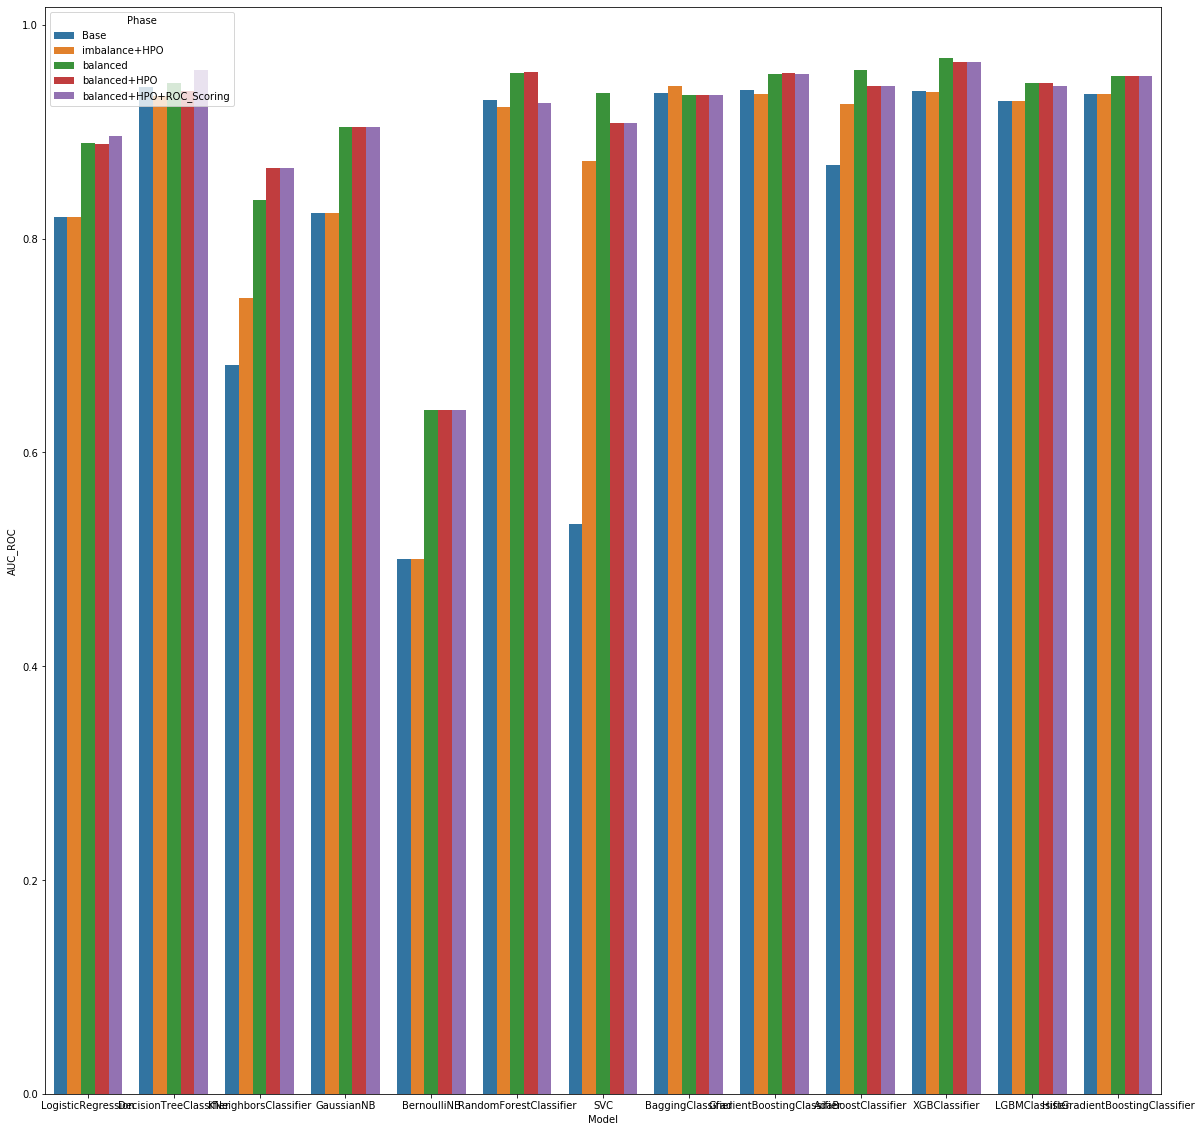

In [542]:
plt.figure(figsize=(20,20))
sns.barplot(y=scores.AUC_ROC,hue=scores.Phase,x=scores.Model);

In [596]:
list(scores.Phase.unique())

['Base',
 'imbalance+HPO',
 'balanced',
 'balanced+HPO',
 'balanced+HPO+ROC_Scoring']

In [551]:
for i in list(scores.Model.unique())[1]:
    scores.groupby('ROC_AUC')['ROC_AUC']<[]

In [597]:
for Model in list(scores.Model.unique()):
    Gdf = scores[scores['Model']==Model]
    if True in list((LRdf[LRdf.Phase=='balanced'].AUC_ROC) > (LRdf[LRdf.Phase=='balanced+HPO+ROC_Scoring'].AUC_ROC)):
        print(Model)
    else:
        print('XX--',Model)

XX-- LogisticRegression
XX-- DecisionTreeClassifier
XX-- KNeighborsClassifier
XX-- GaussianNB
XX-- BernoulliNB
XX-- RandomForestClassifier
XX-- SVC
XX-- BaggingClassifier
XX-- GradientBoostingClassifier
XX-- AdaBoostClassifier
XX-- XGBClassifier
XX-- LGBMClassifier
XX-- HistGradientBoostingClassifier


In [595]:
for Model in list(scores.Model.unique()):
    Gdf = scores[scores['Model']==Model]
    if True in list((LRdf[LRdf.Phase=='balanced'].AUC_ROC) > (LRdf[LRdf.Phase=='balanced+HPO'].AUC_ROC)):
        print(Model)
    else:
        print('XX--',Model)

LogisticRegression
DecisionTreeClassifier
KNeighborsClassifier
GaussianNB
BernoulliNB
RandomForestClassifier
SVC
BaggingClassifier
GradientBoostingClassifier
AdaBoostClassifier
XGBClassifier
LGBMClassifier
HistGradientBoostingClassifier


In [598]:
for Model in list(scores.Model.unique()):
    Gdf = scores[scores['Model']==Model]
    if True in list((LRdf[LRdf.Phase=='balanced+HPO'].AUC_ROC) > (LRdf[LRdf.Phase=='balanced+HPO+ROC_Scoring'].AUC_ROC)):
        print(Model)
    else:
        print('XX--',Model)

XX-- LogisticRegression
XX-- DecisionTreeClassifier
XX-- KNeighborsClassifier
XX-- GaussianNB
XX-- BernoulliNB
XX-- RandomForestClassifier
XX-- SVC
XX-- BaggingClassifier
XX-- GradientBoostingClassifier
XX-- AdaBoostClassifier
XX-- XGBClassifier
XX-- LGBMClassifier
XX-- HistGradientBoostingClassifier


In [609]:
scores[(scores.Phase=='balanced') | (scores.Phase=='balanced+HPO')].sort_values(['AUC_ROC'],
                                        ascending=False)[['Model','AUC_ROC']].head()

,Model,AUC_ROC
0,XGBClassifier,0.969
0,XGBClassifier,0.966
0,AdaBoostClassifier,0.958
0,RandomForestClassifier,0.956
0,RandomForestClassifier,0.955


In [613]:
scores.sort_values(['AUC_ROC','Recall','TestingAccuracy','F1_Score'],
                   ascending=False)[['AUC_ROC','Recall','TestingAccuracy','F1_Score']].head(10)

,AUC_ROC,Recall,TestingAccuracy,F1_Score
0,0.969,0.947,0.986,0.931
0,0.966,0.940,0.986,0.931
0,0.966,0.940,0.986,0.931
0,0.958,0.940,0.972,0.870
0,0.958,0.920,0.988,0.939
0,0.956,0.927,0.979,0.900
0,0.955,0.933,0.973,0.872
0,0.955,0.913,0.988,0.938
0,0.954,0.913,0.987,0.932
0,0.954,0.913,0.987,0.932


In [610]:
scores.columns

Index(['Model', 'Phase', 'AUC_ROC', 'TrainingAccuracy', 'TestingAccuracy',
       'Recall', 'Precision', 'F1_Score', 'FalsePositives', 'FalseNegatives'],
      dtype='object')

In [621]:
index

NameError: name 'index' is not defined

In [616]:
df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Education_cat_Advanced/Professional,Education_cat_Graduate,Education_cat_Undergrad,Personal Loan
ID,,,,,,,,,,,
1,25,1,49.000,4,1.600,1,0.000,0,0,1,0
2,45,19,34.000,3,1.500,1,0.000,0,0,1,0
3,39,15,11.000,1,1.000,1,0.000,0,0,1,0
4,35,9,100.000,1,2.700,2,0.000,0,1,0,0
5,35,8,45.000,4,1.000,2,0.000,0,1,0,0


In [615]:
df.to_csv('bank_personal_loan_modelling_OHE.csv')